Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ARIMA
from pmdarima import auto_arima

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error


Load Processed Data

In [38]:
tsla = pd.read_csv(
    "../data/processed/tsla_processed.csv",
    index_col="Date",
    parse_dates=True
)

# Use 'Close' for modeling
tsla_close = tsla["Close"]


ARIMA Model

Train period: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Test period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00
Train size: 2516, Test size: 259

Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16374.056, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.047 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8183.054
Date:                Mon, 26 Jan 2026   AIC                          16

c:\Users\mihre\Documents\KIAM\week 9\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihre\Documents\KIAM\week 9\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


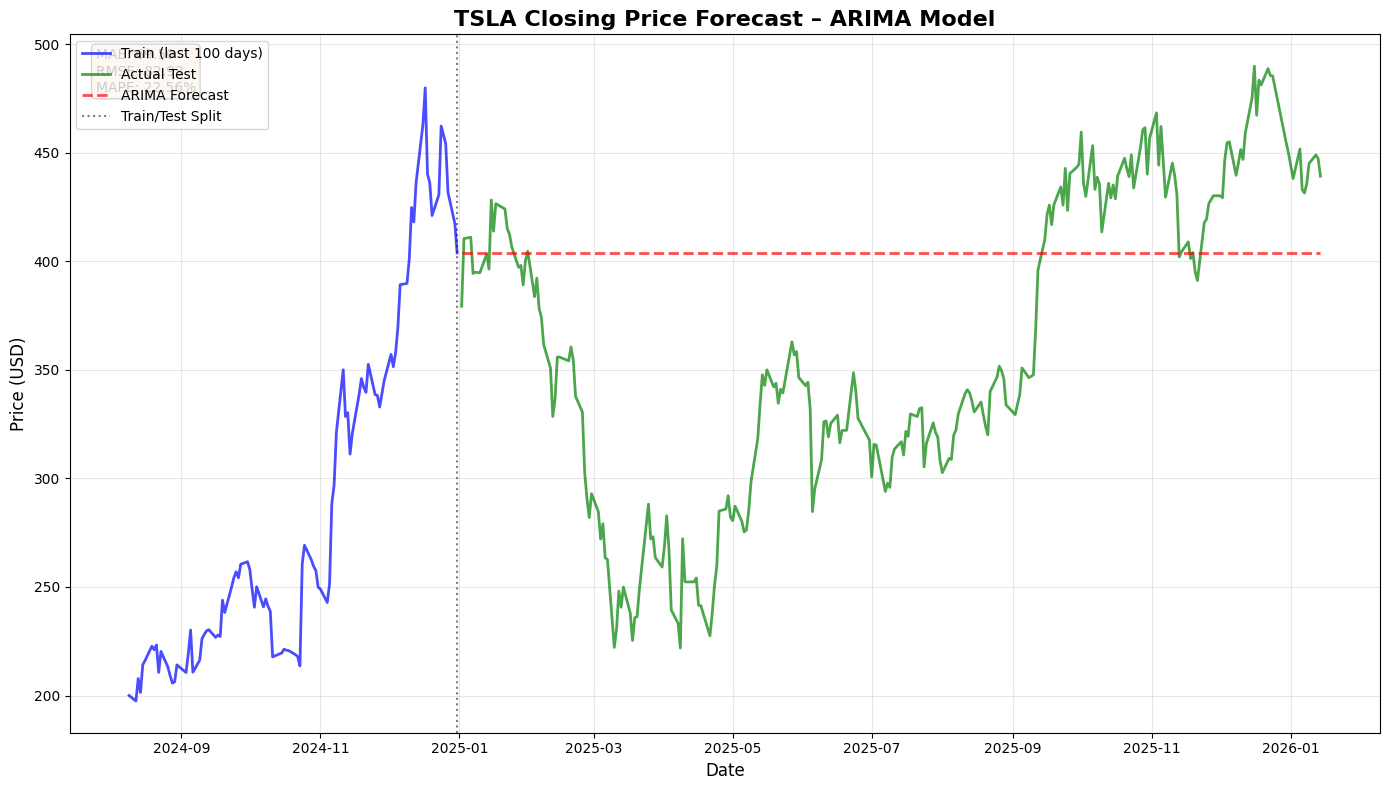

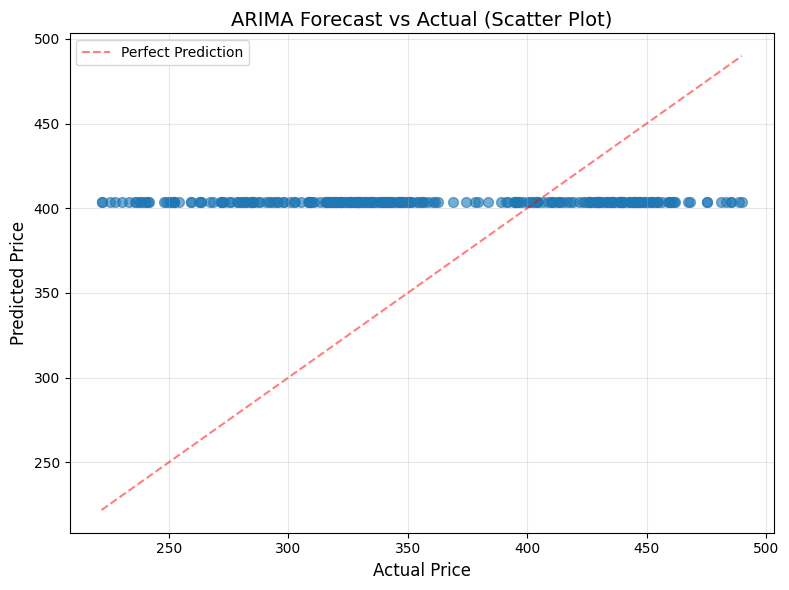

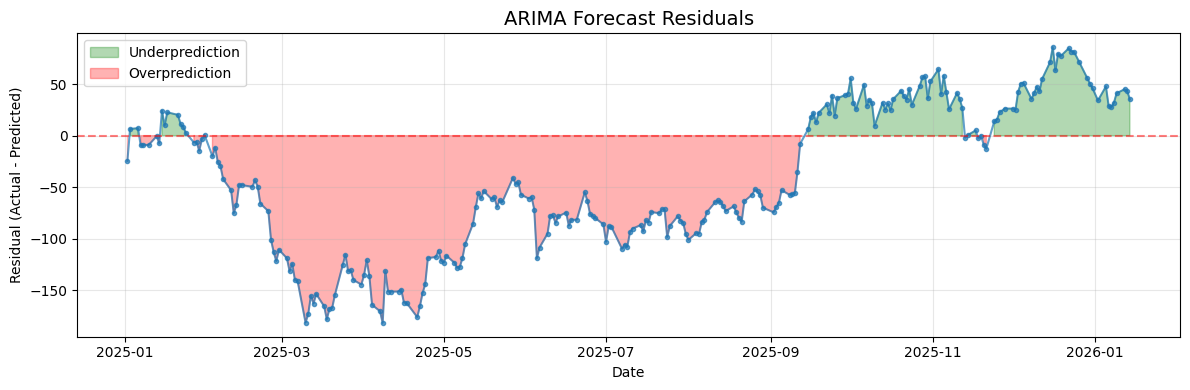


Sample Forecast vs Actual:
            Actual  Forecast  Error
Date                               
2025-01-02  379.28    403.84 -24.56
2025-01-03  410.44    403.84   6.60
2025-01-06  411.05    403.84   7.21
2025-01-07  394.36    403.84  -9.48
2025-01-08  394.94    403.84  -8.90
2025-01-10  394.74    403.84  -9.10
2025-01-13  403.31    403.84  -0.53
2025-01-14  396.36    403.84  -7.48
2025-01-15  428.22    403.84  24.38
2025-01-16  413.82    403.84   9.98


In [42]:


# Split data
train = tsla_close.loc[:"2024-12-31"]
test = tsla_close.loc["2025-01-01":]

print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())
print(f"Train size: {len(train)}, Test size: {len(test)}")

## Find Best ARIMA Parameters Automatically
print("\nFitting ARIMA model...")
arima_model = auto_arima(
    train,
    seasonal=False,
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
print(arima_model.summary())

## Forecast Test Period
print("\nMaking forecast...")
n_test = len(test)

# Try different approaches for forecasting
try:
    # Approach 1: Use predict with n_periods
    forecast_arima = arima_model.predict(n_periods=n_test)
    
    # Create forecast series with proper index
    forecast_arima = pd.Series(forecast_arima, index=test.index)
    
    # Check if forecast contains NaN
    if forecast_arima.isna().any():
        print(f"Warning: Forecast contains {forecast_arima.isna().sum()} NaN values")
        # Fill NaN with last valid value
        forecast_arima = forecast_arima.fillna(method='ffill').fillna(method='bfill')
    
except Exception as e:
    print(f"Error in prediction: {e}")
    
    # Alternative approach: Use the fitted model's forecast method
    try:
        forecast_arima = arima_model.fit(train).forecast(steps=n_test)
        forecast_arima = pd.Series(forecast_arima, index=test.index)
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        # Create a simple forecast (last value)
        forecast_arima = pd.Series([train.iloc[-1]] * n_test, index=test.index)

print(f"Forecast stats - Min: {forecast_arima.min():.2f}, Max: {forecast_arima.max():.2f}")
print(f"NaN in forecast: {forecast_arima.isna().sum()}")

## Evaluate ARIMA
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Make sure both series have the same length and no NaN
test_clean = test.dropna()
forecast_clean = forecast_arima.loc[test_clean.index].dropna()

# Ensure they have the same indices
common_idx = test_clean.index.intersection(forecast_clean.index)
test_eval = test_clean.loc[common_idx]
forecast_eval = forecast_clean.loc[common_idx]

if len(test_eval) > 0:
    mae_arima, rmse_arima, mape_arima = evaluate_forecast(test_eval, forecast_eval)
    print(f"\nARIMA Performance:")
    print(f"MAE: {mae_arima:.2f}")
    print(f"RMSE: {rmse_arima:.2f}")
    print(f"MAPE: {mape_arima:.2f}%")
    
    ## Plot ARIMA Forecast vs Actual
    plt.figure(figsize=(14, 8))
    
    # Plot train data
    plt.plot(train.index[-100:], train[-100:], label="Train (last 100 days)", 
             color='blue', alpha=0.7, linewidth=2)
    
    # Plot test data
    plt.plot(test_eval.index, test_eval, label="Actual Test", 
             color='green', alpha=0.7, linewidth=2)
    
    # Plot forecast
    plt.plot(forecast_eval.index, forecast_eval, label="ARIMA Forecast", 
             color='red', alpha=0.7, linewidth=2, linestyle='--')
    
    # Add vertical line to separate train and test
    plt.axvline(x=train.index[-1], color='black', linestyle=':', alpha=0.5, 
                label='Train/Test Split')
    
    plt.title("TSLA Closing Price Forecast – ARIMA Model", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price (USD)", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Add text box with metrics
    metrics_text = f"MAE: {mae_arima:.2f}\nRMSE: {rmse_arima:.2f}\nMAPE: {mape_arima:.2f}%"
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.show()
    
    # Plot forecast vs actual scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(test_eval, forecast_eval, alpha=0.6, s=50)
    
    # Add perfect prediction line
    min_val = min(test_eval.min(), forecast_eval.min())
    max_val = max(test_eval.max(), forecast_eval.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Prediction')
    
    plt.xlabel("Actual Price", fontsize=12)
    plt.ylabel("Predicted Price", fontsize=12)
    plt.title("ARIMA Forecast vs Actual (Scatter Plot)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    residuals = test_eval - forecast_eval
    plt.figure(figsize=(12, 4))
    plt.plot(residuals.index, residuals, marker='o', markersize=3, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.fill_between(residuals.index, 0, residuals, where=residuals >= 0, 
                     color='green', alpha=0.3, label='Underprediction')
    plt.fill_between(residuals.index, 0, residuals, where=residuals < 0, 
                     color='red', alpha=0.3, label='Overprediction')
    plt.title("ARIMA Forecast Residuals", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print some forecast examples
    print("\nSample Forecast vs Actual:")
    sample_df = pd.DataFrame({
        'Actual': test_eval.head(10),
        'Forecast': forecast_eval.head(10),
        'Error': (test_eval.head(10) - forecast_eval.head(10))
    })
    print(sample_df.round(2))
    
else:
    print("Error: No valid data for evaluation!")
    print(f"Test clean size: {len(test_clean)}")
    print(f"Forecast clean size: {len(forecast_clean)}")
    print(f"Common indices: {len(common_idx)}")
    
    # Try to plot anyway with what we have
    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train, label="Train", color='blue', alpha=0.7)
    if len(test) > 0:
        plt.plot(test.index, test, label="Test", color='green', alpha=0.7)
    if len(forecast_arima) > 0:
        plt.plot(forecast_arima.index, forecast_arima, label="Forecast", 
                color='red', alpha=0.7, linestyle='--')
    plt.title("TSLA Price Data")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

LSTM Mode

Epoch 1/20


c:\Users\mihre\Documents\KIAM\week 9\portfolio-optimization\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.6031e-04 - val_loss: 0.0031
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.6084e-04 - val_loss: 0.0034
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.0263e-04 - val_loss: 0.0034
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.7770e-04 - val_loss: 0.0028
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.9400e-04 - val_loss: 0.0017
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.0026e-04 - val_loss: 0.0016
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.9828e-04 - val_loss: 0.0019
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.8826e-04 - val_loss: 0.0014
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.0032e-04 - val_loss: 0.0013
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.0035e-04 - val_loss: 0.0012
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━

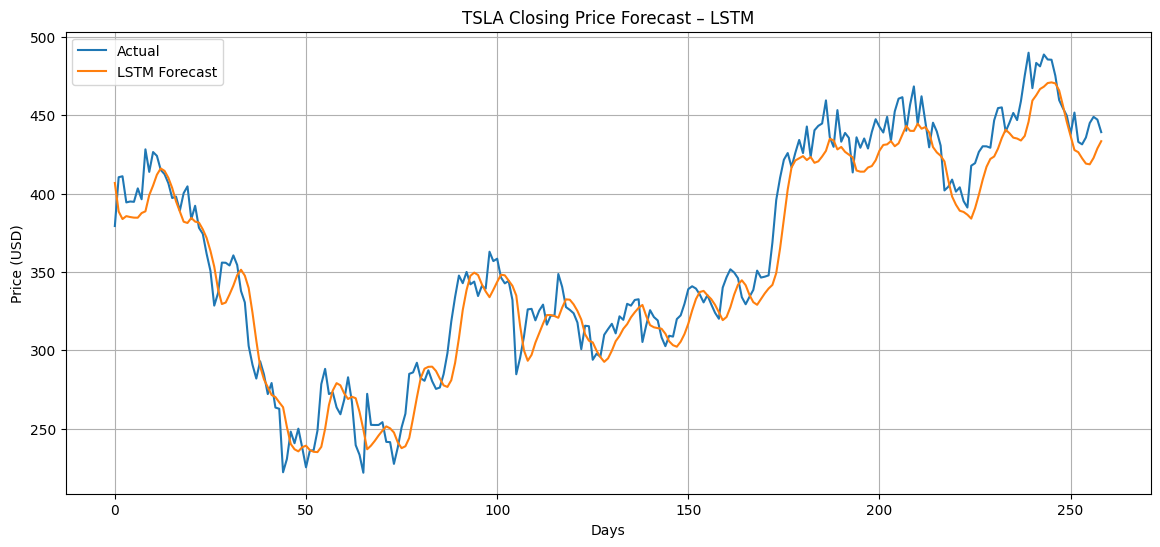

In [43]:
## Scale Data

scaler = MinMaxScaler()
tsla_scaled = scaler.fit_transform(tsla_close.values.reshape(-1,1))


## Create Sequences

def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(tsla_scaled)

##Train-Test Split
split = len(train) - 60  # because first 60 points used for sequence
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## Build LSTM Model

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")


## Train LSTM
history = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


##Forecast LSTM
pred_scaled = lstm_model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))



## Evaluate LSTM
mae_lstm, rmse_lstm, mape_lstm = evaluate_forecast(y_test_actual, pred_lstm)
print(f"LSTM – MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%")


## Plot LSTM Forecast vs Actual
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label="Actual")
plt.plot(pred_lstm, label="LSTM Forecast")
plt.title("TSLA Closing Price Forecast – LSTM")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Model Comparison Table

In [44]:
comparison = pd.DataFrame({
    "Model": ["ARIMA", "LSTM"],
    "MAE": [mae_arima, mae_lstm],
    "RMSE": [rmse_arima, rmse_lstm],
    "MAPE (%)": [mape_arima, mape_lstm]
})

comparison


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,69.498957,82.934613,22.557915
1,LSTM,14.153490,17.867964,4.049490
